## PHYS-253 

## Homework 3

Handed out: Friday, April 11, 2025

**Due: 4.59 pm; Monday, May 5, 2025**

#1 List AI assistants (such as ChatGPT) or Software/Sources you might have used: 
Your answer: ChatGPT

#2 Please, check which way the AI assistant help you [you can check more than one way]:

a) AI helped you better understand the problem;
b) AI helped you start the solution to the problem;
c) AI helped generating the code;
d) AI helped explaining the code;
e) AI helped improving your code. 

Your answer(s): all

#3 Have you been satisfied with your interaction with the AI tool? Please, feel free to say good or bad points.
Your response: Yes

ChatGPT helped me understand better the algorithm of each model and generated code for me. 

[*********************100%***********************]  1 of 1 completed


Next-day prediction shapes:
X_train: (1780, 60, 1) | y_train: (1780, 1)
X_valid: (381, 60, 1) | y_valid: (381, 1)
X_test:  (382, 60, 1) | y_test:  (382, 1)
Seven-day prediction shapes:
X_train: (1775, 60, 1) | y_train: (1775, 1)
X_valid: (381, 60, 1) | y_valid: (381, 1)
X_test:  (381, 60, 1) | y_test:  (381, 1)
Training SimpleRNN...
Training DeepRNN...
Training LSTM...
Training GRU...
Training Bidirectional...


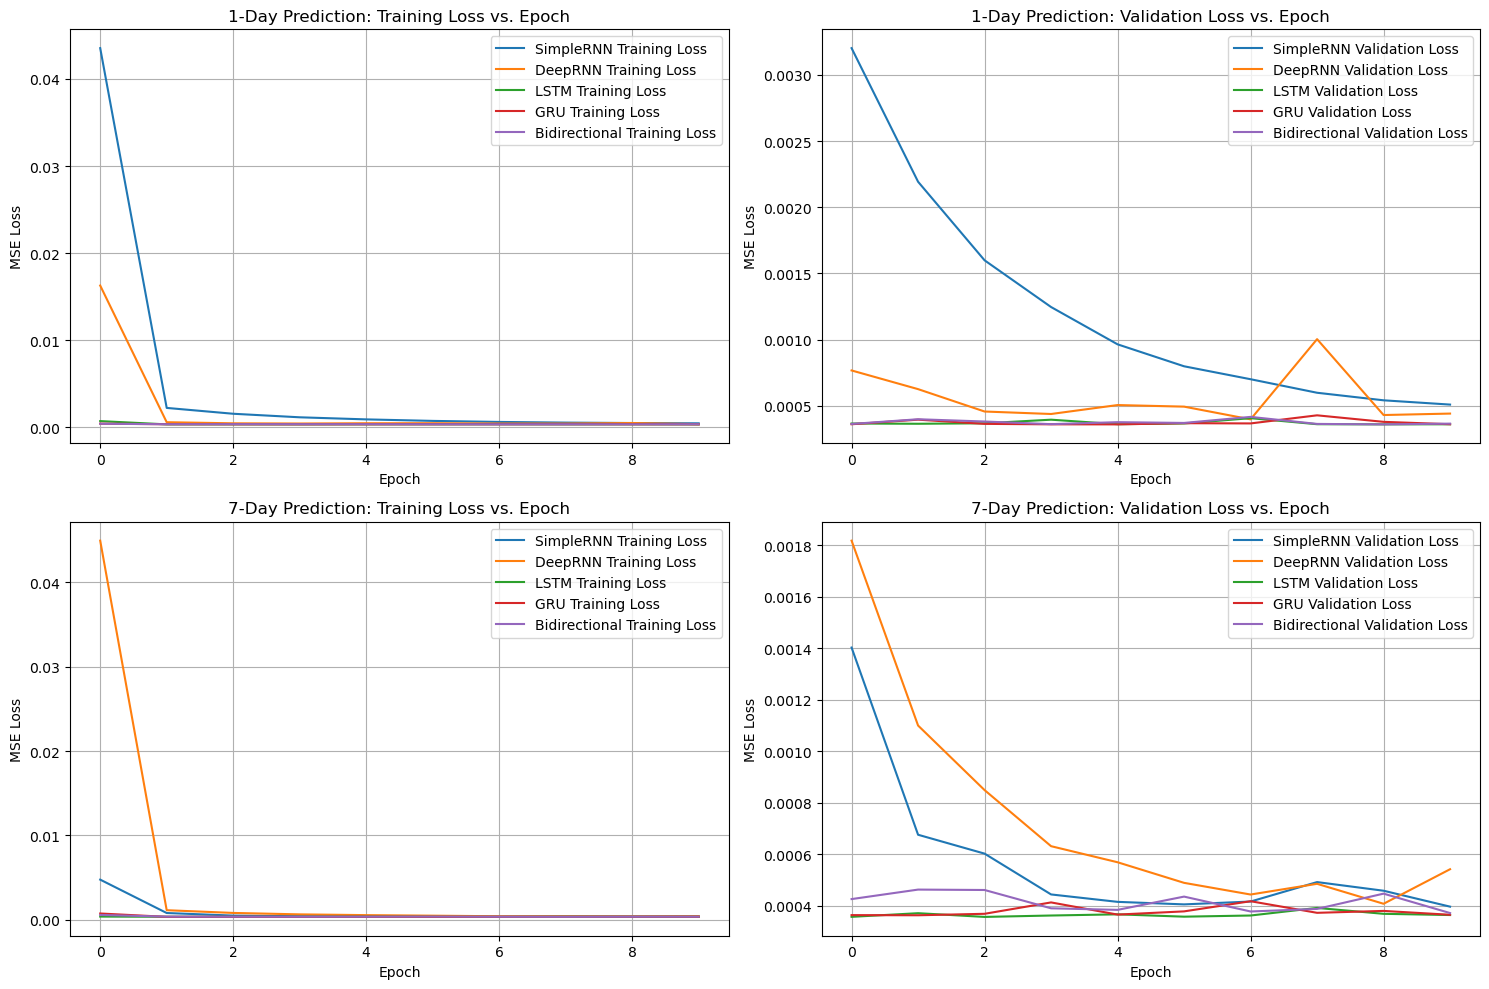

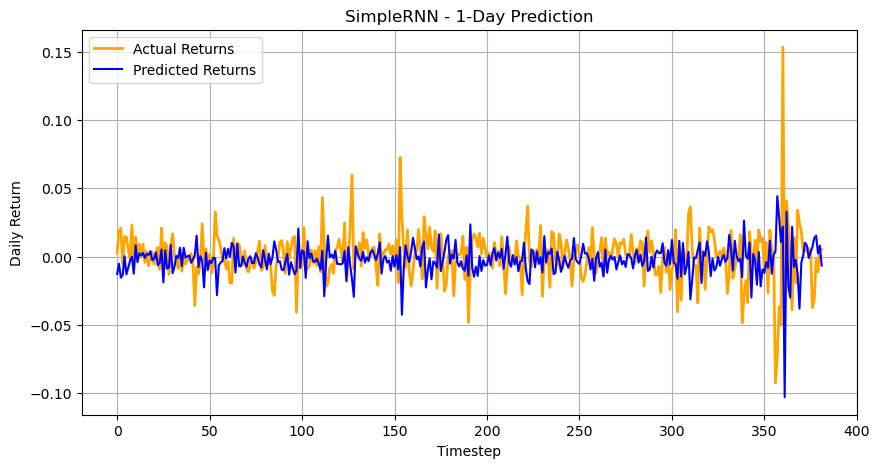

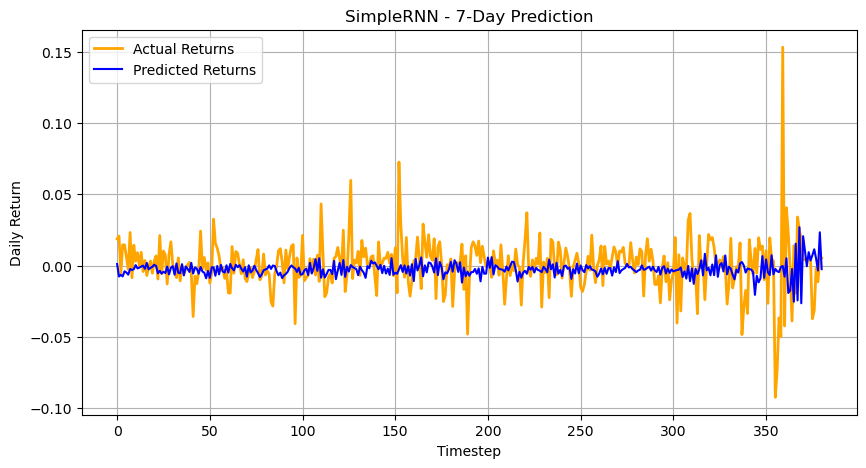

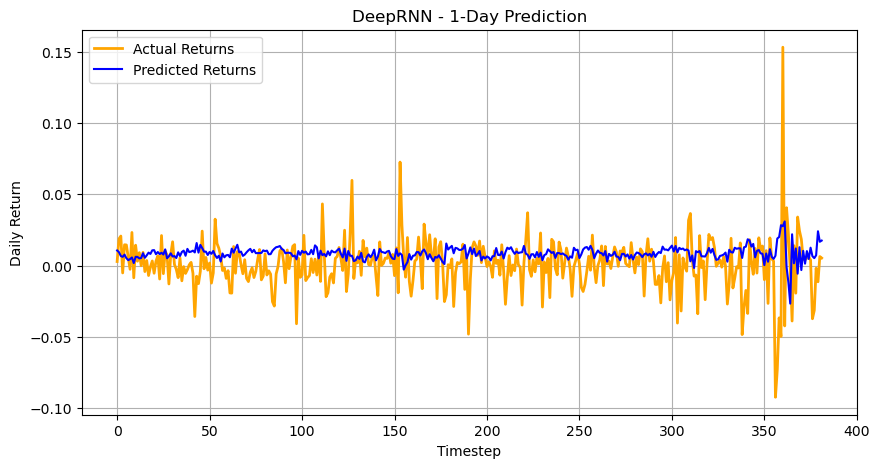

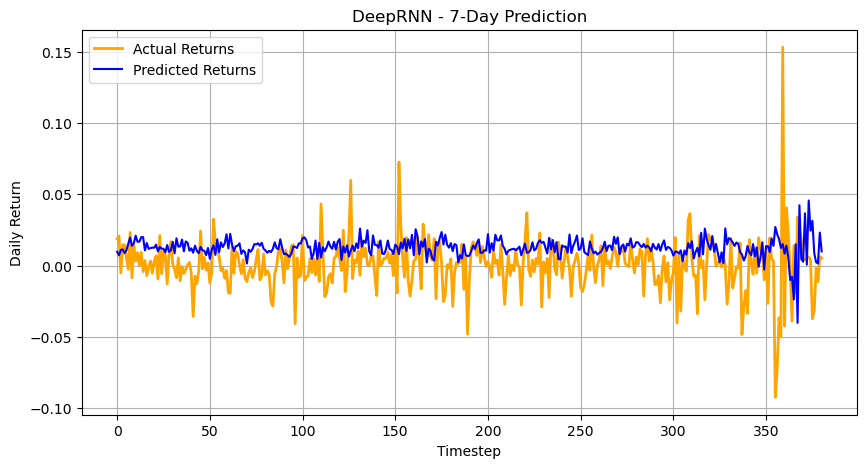

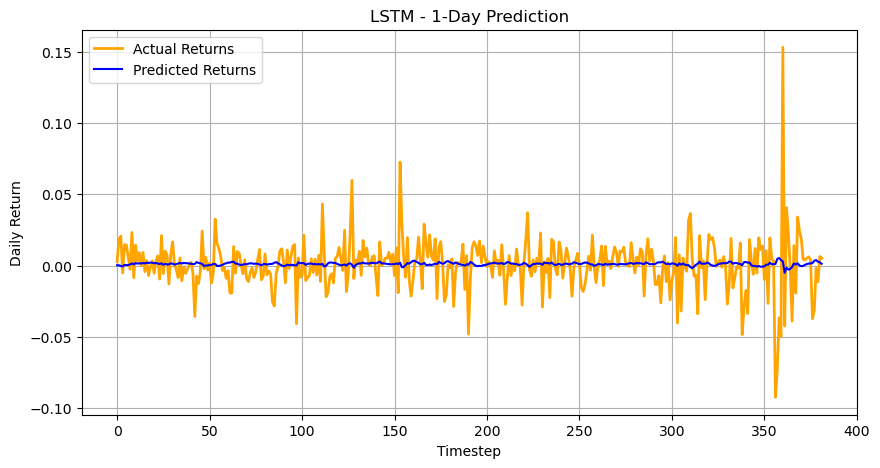

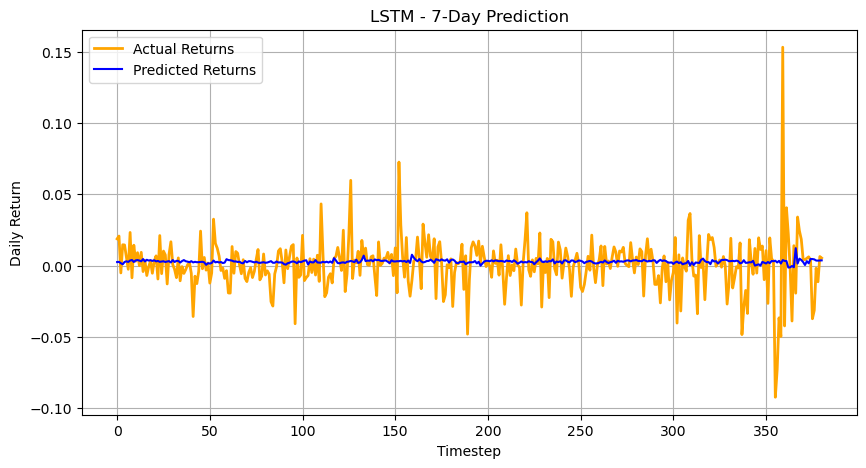

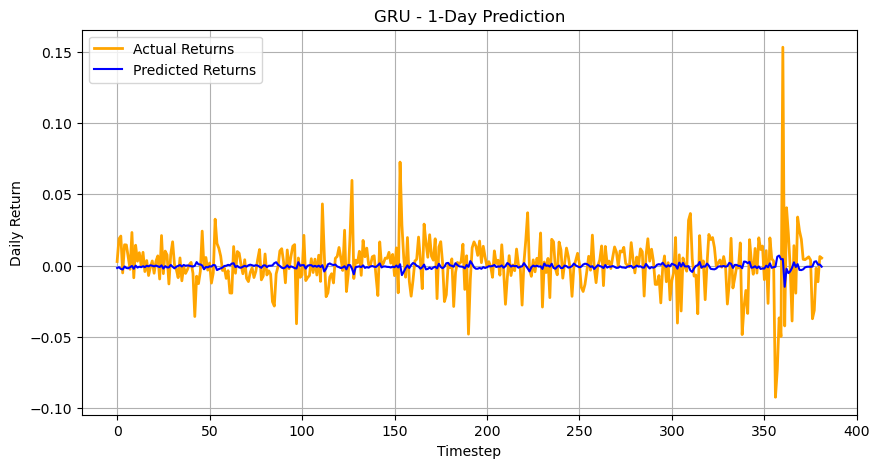

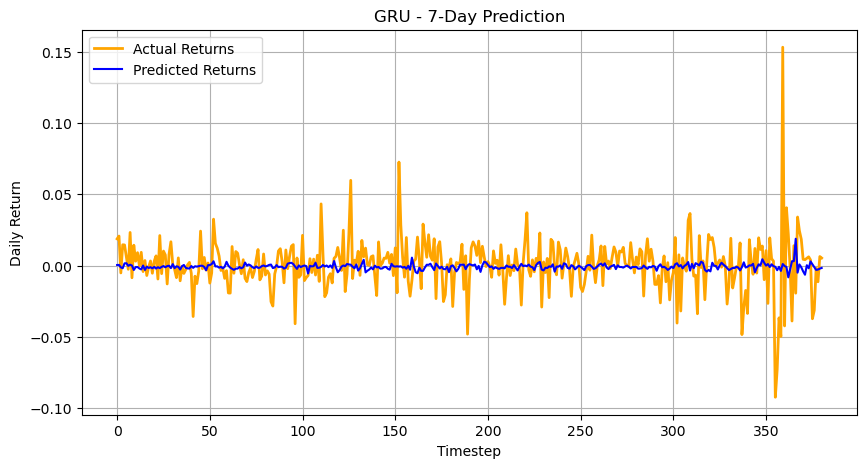

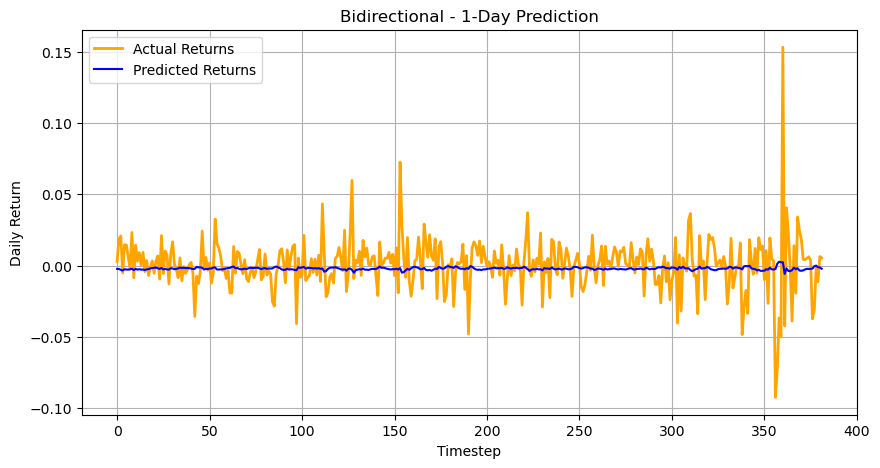

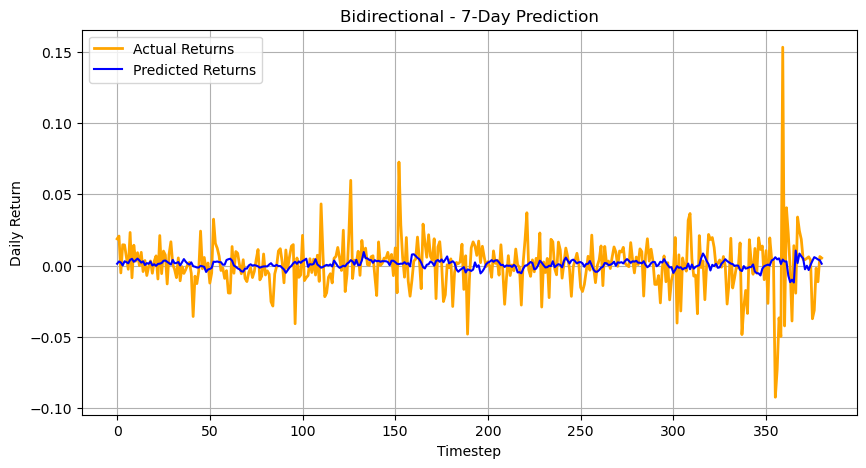


Summary of Model Performance:
           Model  1-Day MSE  1-Day MAE  7-Day MSE  7-Day MAE
0      SimpleRNN   0.000476   0.014979   0.000378   0.013145
1        DeepRNN   0.000428   0.014295   0.000540   0.016909
2           LSTM   0.000337   0.012014   0.000341   0.012078
3            GRU   0.000339   0.012237   0.000341   0.012316
4  Bidirectional   0.000342   0.012437   0.000343   0.012279

Best Model for 1-Day Prediction (lowest MSE): LSTM
Best Model for 7-Day Prediction (lowest MSE): GRU


In [8]:
# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(42)

# Load stock data
stock_symbol = 'AAPL'  # Change to any stock ticker
data = yf.download(stock_symbol, start='2015-01-01', end='2025-05-12')
prices = data['Close']

# Compute daily returns
returns = prices.pct_change().dropna()  # Daily return = (price_t - price_{t-1}) / price_{t-1}

# sequences for RNN
def create_sequences(data, seq_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])  
        y.append(data[i + seq_length + forecast_horizon - 1])  # Target: return at t+forecast_horizon
    return np.array(X), np.array(y)

seq_length = 60  # Use 60 days of returns to predict ##tried also dif
# Next-day prediction (forecast_horizon=1)
X_1day, y_1day = create_sequences(returns.values, seq_length, forecast_horizon=1)
# Seven-day prediction (forecast_horizon=7)
X_7day, y_7day = create_sequences(returns.values, seq_length, forecast_horizon=7)

# Split 
# Next-day
X_train_1day, X_temp_1day, y_train_1day, y_temp_1day = train_test_split(
    X_1day, y_1day, test_size=0.3, random_state=42, shuffle=False)
X_valid_1day, X_test_1day, y_valid_1day, y_test_1day = train_test_split(
    X_temp_1day, y_temp_1day, test_size=0.5, random_state=42, shuffle=False)

# Seven-day
X_train_7day, X_temp_7day, y_train_7day, y_temp_7day = train_test_split(
    X_7day, y_7day, test_size=0.3, random_state=42, shuffle=False)
X_valid_7day, X_test_7day, y_valid_7day, y_test_7day = train_test_split(
    X_temp_7day, y_temp_7day, test_size=0.5, random_state=42, shuffle=False)

# Scale the data
scaler = MinMaxScaler()
X_train_1day = scaler.fit_transform(X_train_1day.reshape(-1, seq_length)).reshape(-1, seq_length, 1)
X_valid_1day = scaler.transform(X_valid_1day.reshape(-1, seq_length)).reshape(-1, seq_length, 1)
X_test_1day = scaler.transform(X_test_1day.reshape(-1, seq_length)).reshape(-1, seq_length, 1)

X_train_7day = scaler.fit_transform(X_train_7day.reshape(-1, seq_length)).reshape(-1, seq_length, 1)
X_valid_7day = scaler.transform(X_valid_7day.reshape(-1, seq_length)).reshape(-1, seq_length, 1)
X_test_7day = scaler.transform(X_test_7day.reshape(-1, seq_length)).reshape(-1, seq_length, 1)

# shapes 
print('Next-day prediction shapes:')
print(f'X_train: {X_train_1day.shape} | y_train: {y_train_1day.shape}')
print(f'X_valid: {X_valid_1day.shape} | y_valid: {y_valid_1day.shape}')
print(f'X_test:  {X_test_1day.shape} | y_test:  {y_test_1day.shape}')
print('Seven-day prediction shapes:')
print(f'X_train: {X_train_7day.shape} | y_train: {y_train_7day.shape}')
print(f'X_valid: {X_valid_7day.shape} | y_valid: {y_valid_7day.shape}')
print(f'X_test:  {X_test_7day.shape} | y_test:  {y_test_7day.shape}')

# Define  models
def build_simple_rnn():
    model = Sequential([
        SimpleRNN(32, input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_deep_rnn():
    model = Sequential([
        SimpleRNN(64, return_sequences=True, input_shape=(seq_length, 1)),
        SimpleRNN(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm():
    model = Sequential([
        LSTM(32, input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru():
    model = Sequential([
        GRU(32, input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bidirectional():
    model = Sequential([
        Bidirectional(LSTM(32), input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# models
models = {
    'SimpleRNN': build_simple_rnn,
    'DeepRNN': build_deep_rnn,
    'LSTM': build_lstm,
    'GRU': build_gru,
    'Bidirectional': build_bidirectional
}

# Train models and store histories
results = {'1day': {}, '7day': {}}

for name, build_fn in models.items():
    print(f'Training {name}...')
    # Next-day 
    model_1day = build_fn()
    history_1day = model_1day.fit(
        X_train_1day, y_train_1day,
        epochs=10,
        batch_size=32,
        validation_data=(X_valid_1day, y_valid_1day),
        verbose=0
    )
    y_pred_1day = model_1day.predict(X_test_1day, verbose=0)
    mse_1day = mean_squared_error(y_test_1day, y_pred_1day)
    mae_1day = mean_absolute_error(y_test_1day, y_pred_1day)
    results['1day'][name] = {
        'mse': mse_1day,
        'mae': mae_1day,
        'predictions': y_pred_1day,
        'history': history_1day.history
    }

    # Seven-day
    model_7day = build_fn()
    history_7day = model_7day.fit(
        X_train_7day, y_train_7day,
        epochs=10,
        batch_size=32,
        validation_data=(X_valid_7day, y_valid_7day),
        verbose=0
    )
    y_pred_7day = model_7day.predict(X_test_7day, verbose=0)
    mse_7day = mean_squared_error(y_test_7day, y_pred_7day)
    mae_7day = mean_absolute_error(y_test_7day, y_pred_7day)
    results['7day'][name] = {
        'mse': mse_7day,
        'mae': mae_7day,
        'predictions': y_pred_7day,
        'history': history_7day.history
    }

# Plot Loss vs. Epochs
plt.figure(figsize=(15, 10))

# 1-Day 
plt.subplot(2, 2, 1)
for name in models:
    plt.plot(results['1day'][name]['history']['loss'], label=f'{name} Training Loss')
plt.title('1-Day Prediction: Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for name in models:
    plt.plot(results['1day'][name]['history']['val_loss'], label=f'{name} Validation Loss')
plt.title('1-Day Prediction: Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# 7-Day 
plt.subplot(2, 2, 3)
for name in models:
    plt.plot(results['7day'][name]['history']['loss'], label=f'{name} Training Loss')
plt.title('7-Day Prediction: Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for name in models:
    plt.plot(results['7day'][name]['history']['val_loss'], label=f'{name} Validation Loss')
plt.title('7-Day Prediction: Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot Predictions vs. Actual
for name in models:
    # 1-Day Prediction
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_1day, label='Actual Returns', color='orange', linewidth=2)
    plt.plot(results['1day'][name]['predictions'], label='Predicted Returns', color='blue')
    plt.title(f'{name} - 1-Day Prediction')
    plt.xlabel('Timestep')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 7-Day Prediction
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_7day, label='Actual Returns', color='orange', linewidth=2)
    plt.plot(results['7day'][name]['predictions'], label='Predicted Returns', color='blue')
    plt.title(f'{name} - 7-Day Prediction')
    plt.xlabel('Timestep')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# summary Table of Metrics
metrics_data = {
    'Model': [],
    '1-Day MSE': [],
    '1-Day MAE': [],
    '7-Day MSE': [],
    '7-Day MAE': []
}

for name in models:
    metrics_data['Model'].append(name)
    metrics_data['1-Day MSE'].append(results['1day'][name]['mse'])
    metrics_data['1-Day MAE'].append(results['1day'][name]['mae'])
    metrics_data['7-Day MSE'].append(results['7day'][name]['mse'])
    metrics_data['7-Day MAE'].append(results['7day'][name]['mae'])

metrics_df = pd.DataFrame(metrics_data)
print("\nSummary of Model Performance:")
print(metrics_df)

# Best Model
best_1day_model = metrics_df.loc[metrics_df['1-Day MSE'].idxmin()]['Model']
best_7day_model = metrics_df.loc[metrics_df['7-Day MSE'].idxmin()]['Model']
print(f"\nBest Model for 1-Day Prediction (lowest MSE): {best_1day_model}")
print(f"Best Model for 7-Day Prediction (lowest MSE): {best_7day_model}")
